<a href="https://colab.research.google.com/github/pratapmicrosoft/MLAI/blob/main/Session_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [36]:
# CUDA?
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("CUDA Available?", device)

CUDA Available? cuda


CODE BLOCK: 3

In [37]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [38]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [39]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

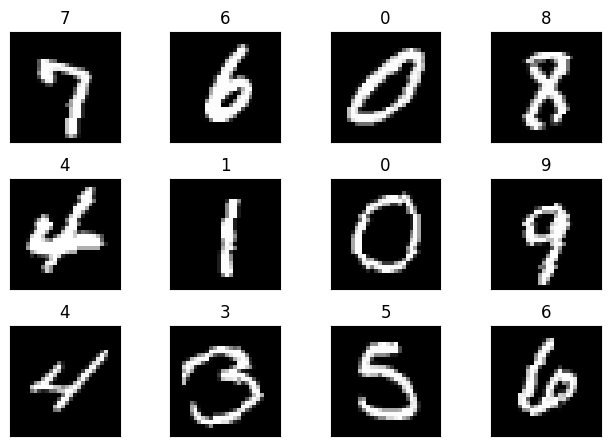

In [40]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [80]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        print(x.shape)
        x = F.relu(self.conv1(x), 2)
        print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) 
        print(x.shape)
        x = F.relu(self.conv3(x), 2)
        print(x.shape)
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) 
        print(x.shape)
        x = x.view(-1, 4096)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [56]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 8

In [57]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

CODE BLOCK: 9

In [81]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=2.3045 Batch_id=1 Accuracy=7.42:   1%|          | 1/118 [00:00<00:58,  2.01it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.3063 Batch_id=3 Accuracy=7.08:   3%|▎         | 3/118 [00:00<00:29,  3.88it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.3063 Batch_id=5 Accuracy=7.03:   4%|▍         | 5/118 [00:01<00:25,  4.47it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.3022 Batch_id=7 Accuracy=7.28:   6%|▌         | 7/118 [00:01<00:22,  5.03it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.3000 Batch_id=9 Accuracy=7.68:   8%|▊         | 9/118 [00:01<00:20,  5.35it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2991 Batch_id=11 Accuracy=8.17:   9%|▉         | 11/118 [00:02<00:22,  4.74it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2912 Batch_id=13 Accuracy=8.71:  11%|█         | 13/118 [00:03<00:25,  4.08it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2898 Batch_id=15 Accuracy=9.78:  13%|█▎        | 15/118 [00:03<00:27,  3.79it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2917 Batch_id=17 Accuracy=10.63:  14%|█▍        | 17/118 [00:04<00:27,  3.73it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2900 Batch_id=19 Accuracy=11.30:  16%|█▌        | 19/118 [00:04<00:26,  3.76it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2795 Batch_id=21 Accuracy=11.81:  18%|█▊        | 21/118 [00:05<00:23,  4.17it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2714 Batch_id=23 Accuracy=12.67:  19%|█▉        | 23/118 [00:05<00:20,  4.56it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2639 Batch_id=25 Accuracy=13.84:  21%|██        | 25/118 [00:05<00:18,  5.01it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2590 Batch_id=27 Accuracy=15.09:  23%|██▎       | 27/118 [00:06<00:17,  5.26it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2402 Batch_id=29 Accuracy=16.52:  25%|██▍       | 29/118 [00:06<00:16,  5.46it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2207 Batch_id=31 Accuracy=17.74:  26%|██▋       | 31/118 [00:06<00:15,  5.78it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2033 Batch_id=33 Accuracy=18.99:  28%|██▊       | 33/118 [00:07<00:14,  5.92it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.1586 Batch_id=35 Accuracy=20.14:  30%|██▉       | 35/118 [00:07<00:13,  6.07it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.1128 Batch_id=37 Accuracy=21.25:  31%|███▏      | 37/118 [00:07<00:13,  6.16it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.0319 Batch_id=39 Accuracy=22.70:  33%|███▎      | 39/118 [00:08<00:13,  5.88it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=1.9107 Batch_id=41 Accuracy=24.38:  35%|███▍      | 41/118 [00:08<00:13,  5.86it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=1.7000 Batch_id=43 Accuracy=25.98:  36%|███▋      | 43/118 [00:08<00:12,  6.03it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=1.3647 Batch_id=45 Accuracy=27.54:  38%|███▊      | 45/118 [00:09<00:12,  6.00it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=1.2395 Batch_id=47 Accuracy=28.95:  40%|███▉      | 47/118 [00:09<00:12,  5.85it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=1.5102 Batch_id=49 Accuracy=30.11:  42%|████▏     | 49/118 [00:09<00:11,  5.97it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=5.2503 Batch_id=51 Accuracy=30.20:  43%|████▎     | 51/118 [00:10<00:11,  5.94it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.9762 Batch_id=53 Accuracy=30.17:  45%|████▍     | 53/118 [00:10<00:11,  5.84it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.1846 Batch_id=55 Accuracy=30.32:  47%|████▋     | 55/118 [00:10<00:10,  5.73it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2698 Batch_id=57 Accuracy=30.15:  48%|████▊     | 57/118 [00:11<00:10,  5.73it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2929 Batch_id=59 Accuracy=29.71:  50%|█████     | 59/118 [00:11<00:10,  5.64it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2941 Batch_id=61 Accuracy=29.22:  53%|█████▎    | 62/118 [00:11<00:09,  6.07it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2913 Batch_id=63 Accuracy=28.74:  54%|█████▍    | 64/118 [00:12<00:08,  6.05it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2928 Batch_id=65 Accuracy=28.28:  56%|█████▌    | 66/118 [00:12<00:08,  5.85it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2915 Batch_id=66 Accuracy=28.08:  57%|█████▋    | 67/118 [00:12<00:09,  5.66it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2950 Batch_id=68 Accuracy=27.70:  58%|█████▊    | 69/118 [00:13<00:08,  5.68it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2858 Batch_id=70 Accuracy=27.57:  60%|██████    | 71/118 [00:13<00:08,  5.78it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2952 Batch_id=72 Accuracy=27.49:  62%|██████▏   | 73/118 [00:13<00:07,  5.97it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2893 Batch_id=74 Accuracy=27.44:  64%|██████▎   | 75/118 [00:14<00:07,  5.80it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2813 Batch_id=76 Accuracy=27.39:  65%|██████▌   | 77/118 [00:14<00:06,  6.04it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2853 Batch_id=77 Accuracy=27.33:  66%|██████▌   | 78/118 [00:14<00:07,  5.31it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2830 Batch_id=78 Accuracy=27.30:  67%|██████▋   | 79/118 [00:15<00:07,  4.89it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2770 Batch_id=79 Accuracy=27.33:  68%|██████▊   | 80/118 [00:15<00:08,  4.23it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2772 Batch_id=81 Accuracy=27.33:  69%|██████▉   | 82/118 [00:15<00:09,  3.67it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2724 Batch_id=82 Accuracy=27.34:  70%|███████   | 83/118 [00:16<00:08,  3.91it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2655 Batch_id=84 Accuracy=27.30:  71%|███████   | 84/118 [00:16<00:10,  3.12it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2696 Batch_id=85 Accuracy=27.25:  73%|███████▎  | 86/118 [00:17<00:09,  3.41it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2657 Batch_id=87 Accuracy=27.15:  75%|███████▍  | 88/118 [00:17<00:07,  3.80it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2632 Batch_id=89 Accuracy=27.14:  75%|███████▌  | 89/118 [00:17<00:07,  3.69it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2467 Batch_id=91 Accuracy=27.17:  78%|███████▊  | 92/118 [00:18<00:05,  4.98it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2251 Batch_id=93 Accuracy=27.31:  80%|███████▉  | 94/118 [00:18<00:04,  5.44it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2258 Batch_id=95 Accuracy=27.51:  81%|████████  | 95/118 [00:19<00:04,  5.00it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.2032 Batch_id=97 Accuracy=27.70:  82%|████████▏ | 97/118 [00:19<00:03,  5.31it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.1946 Batch_id=99 Accuracy=27.85:  84%|████████▍ | 99/118 [00:19<00:03,  5.37it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.1616 Batch_id=101 Accuracy=27.98:  86%|████████▌ | 101/118 [00:20<00:03,  5.47it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.1156 Batch_id=103 Accuracy=28.13:  87%|████████▋ | 103/118 [00:20<00:02,  5.63it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.1100 Batch_id=105 Accuracy=28.24:  89%|████████▉ | 105/118 [00:20<00:02,  5.69it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=2.0768 Batch_id=107 Accuracy=28.32:  91%|█████████ | 107/118 [00:21<00:01,  5.72it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=1.9891 Batch_id=109 Accuracy=28.44:  92%|█████████▏| 109/118 [00:21<00:01,  5.64it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=1.8834 Batch_id=111 Accuracy=28.58:  94%|█████████▍| 111/118 [00:21<00:01,  5.69it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=1.8194 Batch_id=113 Accuracy=28.72:  96%|█████████▌| 113/118 [00:22<00:00,  5.77it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=1.7433 Batch_id=115 Accuracy=28.86:  97%|█████████▋| 115/118 [00:22<00:00,  5.71it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])


Train: Loss=1.5723 Batch_id=117 Accuracy=29.02: 100%|██████████| 118/118 [00:22<00:00,  5.19it/s]

torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([96, 1, 28, 28])
torch.Size([96, 32, 26, 26])
torch.Size([96, 64, 12, 12])
torch.Size([96, 128, 10, 10])
torch.Size([96, 256, 4, 4])


torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 128, 10, 10])
torch.Size([512, 256, 4, 4])
torch.Size([512, 1, 28, 28])
torch.Size([512, 32, 26, 26])
torch.Size([512, 64, 12, 12])
torch.Size([512, 

Text(0.5, 1.0, 'Test Accuracy')

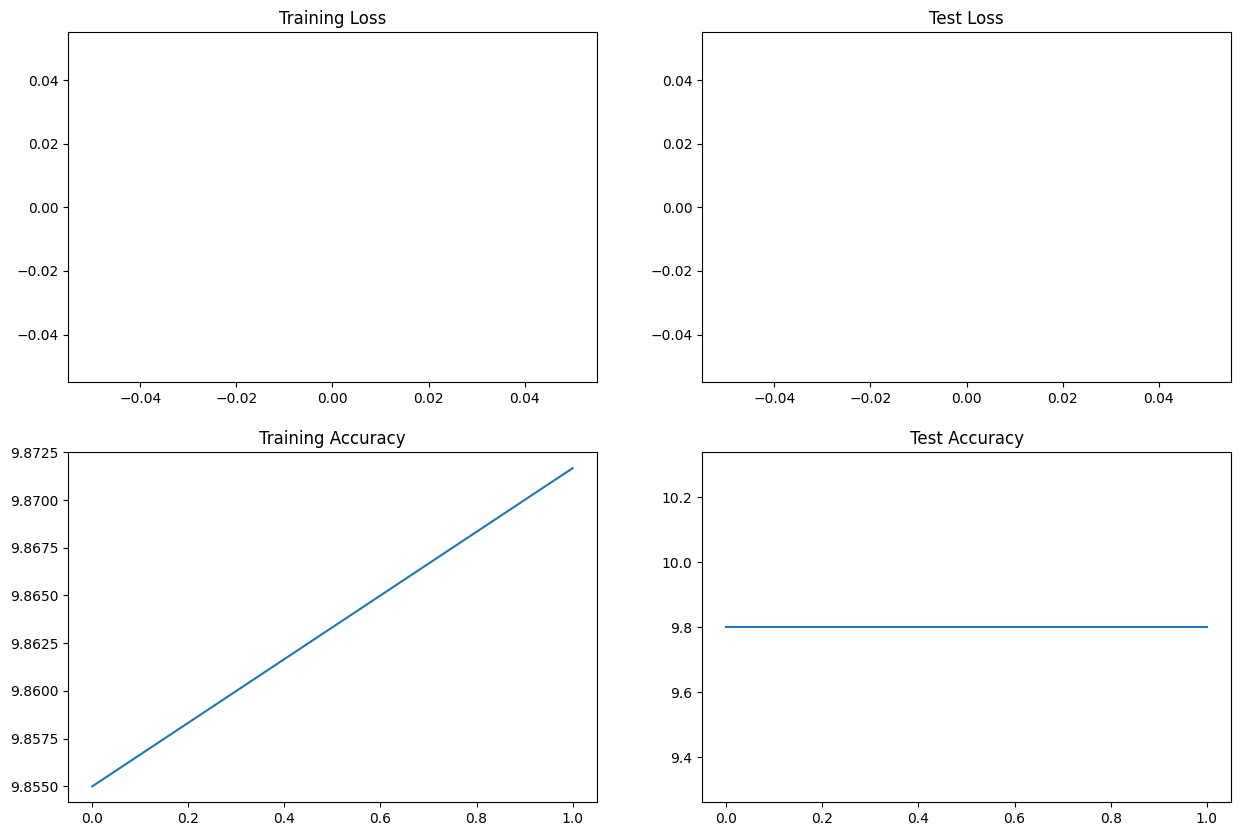

In [76]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [82]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
torch.Size([2, 1, 28, 28])
torch.Size([2, 32, 26, 26])
torch.Size([2, 64, 12, 12])
torch.Size([2, 128, 10, 10])
torch.Size([2, 256, 4, 4])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.